<a href="https://colab.research.google.com/github/flat35hd99/calc_diffusion_coefficient_by_lj/blob/main/calc_diffusion_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/flat35hd99/calc_diffusion_coefficient_by_lj.git "calc"

Cloning into 'calc'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 74 (delta 39), reused 65 (delta 33), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
%%bash
cd calc
mkdir output
make
time ./a.out > output/energy.dot 

g++ -std=c++11 -march=native -Wall -Wextra -O3 -c main.cpp 
g++ -std=c++11 -march=native -Wall -Wextra -O3 -c md.cpp 
g++ -std=c++11 -march=native -Wall -Wextra -O3 -c observer.cpp 
g++ -std=c++11 -march=native -Wall -Wextra -O3 -c systemparam.cpp 
g++ -std=c++11 -march=native -Wall -Wextra -O3 -c variables.cpp 
g++ -std=c++11 -march=native -Wall -Wextra -O3  -o a.out main.o md.o observer.o systemparam.o variables.o



real	0m11.191s
user	0m10.858s
sys	0m0.273s


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
 
energy_df = pd.read_table('calc/output/energy.dot', header=None, delim_whitespace=True, names=['step','K', 'V', 'total']).drop('step', axis=1)
velocity_df = pd.read_csv("calc/output/velocity.csv", header=0).drop('index', axis=1)

In [ ]:
velocity_df.head()

,px0,py0,pz0,px1,py1,pz1,px2,py2,pz2,px3,py3,pz3,px4,py4,pz4,px5,py5,pz5,px6,py6,pz6,px7,py7,pz7,px8,py8,pz8,px9,py9,pz9,px10,py10,pz10,px11,py11,pz11,px12,py12,pz12,px13,...,px487,py487,pz487,px488,py488,pz488,px489,py489,pz489,px490,py490,pz490,px491,py491,pz491,px492,py492,pz492,px493,py493,pz493,px494,py494,pz494,px495,py495,pz495,px496,py496,pz496,px497,py497,pz497,px498,py498,pz498,px499,py499,pz499,Unnamed: 1501
0,0.729257,-0.308426,-0.596371,-0.419814,0.058059,0.928926,0.550690,0.785543,-0.325463,0.692311,0.643337,0.431190,-0.648328,-0.724840,0.003816,-0.291799,-0.688555,0.669918,-0.831653,-0.503256,0.030587,-0.024655,0.912428,0.472973,-0.808286,0.563147,0.125879,0.772742,-0.129292,-0.612566,-0.192118,0.903611,-0.372499,0.289862,0.598312,-0.734149,-0.892491,-0.386060,0.022044,0.114423,...,0.739697,0.362851,-0.571579,-0.898670,0.304302,-0.224563,0.135223,0.366470,-0.896196,-0.920540,-0.078423,-0.283365,-0.880047,-0.262134,-0.293537,0.150471,-0.918985,-0.299129,0.149230,-0.401354,0.933684,-0.824685,0.074543,0.560209,0.992392,-0.086766,-0.190983,0.827300,-0.069497,-0.555040,0.051939,0.783969,0.672672,0.546383,0.430338,0.777945,0.217456,-0.884600,-0.356628,NaN
1,0.667783,-0.278821,-0.582226,-0.360977,0.059085,0.934343,0.552877,0.769193,-0.327090,0.696254,0.647770,0.399463,-0.632176,-0.686107,0.022067,-0.300664,-0.690766,0.671171,-0.835523,-0.518325,0.033322,-0.024897,0.916851,0.455926,-0.740365,0.542866,0.116879,0.720797,-0.132690,-0.616890,-0.192975,0.861262,-0.375468,0.294447,0.601088,-0.699391,-0.845932,-0.367692,-0.002432,0.103443,...,0.744619,0.365471,-0.574689,-0.856281,0.277678,-0.232805,0.133598,0.367122,-0.899858,-0.922778,-0.073776,-0.285762,-0.883843,-0.260115,-0.292417,0.169489,-0.894952,-0.301168,0.143893,-0.401788,0.937677,-0.827703,0.068262,0.562671,0.995650,-0.085708,-0.201011,0.796915,-0.054919,-0.550339,0.085250,0.787963,0.674210,0.548767,0.389061,0.782930,0.217042,-0.887995,-0.364689,NaN
2,0.499080,-0.195798,-0.543466,-0.201134,0.062204,0.947476,0.555947,0.722641,-0.328466,0.704872,0.657118,0.313770,-0.583576,-0.568772,0.071666,-0.325786,-0.693961,0.674824,-0.843811,-0.555652,0.037975,-0.022184,0.926087,0.402848,-0.545275,0.487318,0.084526,0.577746,-0.139082,-0.626392,-0.196971,0.721848,-0.380984,0.304513,0.605420,-0.594451,-0.702021,-0.317219,-0.067205,0.075800,...,0.755130,0.369631,-0.577974,-0.729018,0.199364,-0.261243,0.127070,0.368948,-0.906480,-0.926084,-0.060045,-0.289296,-0.891725,-0.257686,-0.289177,0.220425,-0.826751,-0.307772,0.127689,-0.403218,0.946105,-0.835635,0.049499,0.569143,1.001830,-0.082687,-0.234786,0.705596,-0.020452,-0.532785,0.179279,0.796563,0.679574,0.553179,0.258205,0.795107,0.215939,-0.897990,-0.382161,NaN
3,0.255048,-0.075186,-0.488543,0.027518,0.067277,0.968932,0.560113,0.651617,-0.329688,0.718424,0.670728,0.190987,-0.510587,-0.385097,0.140092,-0.364302,-0.698746,0.680915,-0.856957,-0.603346,0.044573,-0.017022,0.939820,0.318564,-0.252505,0.405569,0.031403,0.373664,-0.148086,-0.641052,-0.205808,0.486654,-0.389351,0.319691,0.611131,-0.430786,-0.471831,-0.243673,-0.160334,0.039081,...,0.770485,0.375315,-0.576378,-0.529460,0.079616,-0.308187,0.116383,0.371866,-0.915424,-0.931110,-0.039353,-0.293755,-0.904081,-0.254803,-0.285089,0.292556,-0.727264,-0.320211,0.101115,-0.405753,0.959268,-0.847308,0.022341,0.578706,1.011120,-0.077981,-0.289794,0.565825,0.021900,-0.505040,0.316300,0.810130,0.689519,0.561006,0.046976,0.815847,0.214386,-0.914021,-0.402960,NaN
4,-0.021296,0.065822,-0.422000,0.278026,0.073792,0.998283,0.565609,0.557829,-0.330821,0.736627,0.687580,0.050181,-0.423223,-0.174771,0.211074,-0.412794,-0.706110,0.689733,-0.875316,-0.643542,0.053010,-0.010172,0.958110,0.209957,0.084143,0.302181,-0.033533,0.145139,-0.158799,-0.660095,-0.219989,0.180533,-0.400679,0.339048,0.618457,-0.228242,-0.184040,-0.152755,-0.265374,0.000342,...,0.790229,0.382600,-0.563266,-0.280824,-0.068259,-0.369756,0.105661,0.375889,-0.926342,-0.938867,-0.015986,-0.298715,-0.921518,-0.251351,-0.282556,0.367

In [ ]:
energy_df.head()

,K,V,total
0,0.499049,-1.03564,-0.536595
1,1.870870,-2.41093,-0.540060
2,1.903160,-2.44238,-0.539224
3,1.910250,-2.44947,-0.539219
4,1.829730,-2.37045,-0.540712


<Figure size 432x288 with 0 Axes>

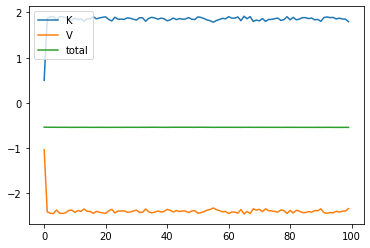

In [ ]:
plt.figure()
energy_df.plot()

In [ ]:
velocity_df.sum(axis=1)

0      -9.060000e-07
1       2.340000e-06
2       1.605800e-05
3       2.800000e-05
4      -4.369000e-05
            ...     
9995    2.028800e-05
9996   -1.459400e-04
9997   -7.698100e-05
9998   -7.620000e-06
9999    3.114000e-06
Length: 10000, dtype: float64

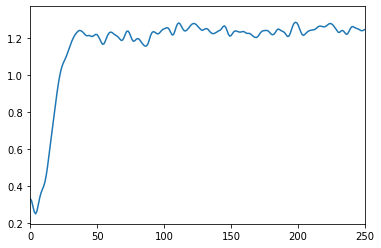

In [ ]:
plt.figure()
plt.axis(xmax=250)
velocity_df.var(axis=1).plot()

ここまでで
 - 運動エネルギーとポテンシャルエネルギーの総和が保存していること
 - 速度の分散は観測一回目、すなわち初期状態以降はほとんど一定（**定量的に評価したい**）であること

以上のことがわかった。

ここからは拡散定数$D$を速度の自己相関関数から求める。このとき、熱平衡に達しているという条件と観測した時間$t$の長さが十分であるとして、教科書の近似を行い、それによって得られた式

$$
    D = \frac{1}{3} \int^{\tau}_{0} \left< v(0) \cdot v(t) \right>dt
$$

を利用する。

$$
D = \frac{1}{3} \sum^{\tau}_{t = 0}\left< v(0) \cdot v(t) \right>
$$

In [ ]:
velocity_df.columns

Index(['px0', 'py0', 'pz0', 'px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'px3',
       ...
       'px497', 'py497', 'pz497', 'px498', 'py498', 'pz498', 'px499', 'py499',
       'pz499', 'Unnamed: 1501'],
      dtype='object', length=1501)

In [ ]:
velocity_df.index

RangeIndex(start=0, stop=10000, step=1)

In [ ]:
TIME_SHIFT = 100
STEPS = 10000

In [ ]:
velocity_df.iloc[0][0]

0.7292569999999999

In [ ]:
def velocity_autocorrelation_function(t_max, v_df):
    numbers_of_reiteration = STEPS//(TIME_SHIFT + t_max)
    product_start_and_end_df = pd.DataFrame(index=velocity_df.index)
    for i in range(1, numbers_of_reiteration):
        start_point = i * (t_max + TIME_SHIFT)
        end_point = start_point + t_max
        start_points_df = v_df[::start_point]
        end_points_df = v_df[::end_point]
        if (len(start_points_df.index) < len(end_points_df.index)):
            end_points_df.drop(end_points_df.index[-1], inplace=True)
        product_start_and_end_df = start_points_df * end_points_df
    print(product_start_and_end_df.head()

velocity_autocorrelation_function(1, velocity_df)

px0    0.531816
py0    0.095127
pz0    0.355658
px1    0.176244
py1    0.003371
dtype: float64
